## Variance vs. inertia plots for 2afc (rates) models

In [1]:
cd /Users/cl1704/PycharmProjects/clustering_in_rnns

/Users/cl1704/PycharmProjects/clustering_in_rnns


In [2]:
def compute_var(variance,n):
    return np.sum(variance[n:])

def compute_p(k, null_k):
    return (np.sum(null_k<k)/len(null_k))

In [3]:
from Experiment_1.TwoAFCTask import generate_trials
#from Experiment_5.SiegelMillerTask import generate_trials
import networkx as nx
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
from Experiment_1.net import *
import os
import statsmodels.api as sm
import scipy.optimize as opt
import math
#from psychometrics import *
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import networkx as nx
from sklearn.cluster import KMeans
plt.rcParams["axes.grid"] = False
from sklearn.manifold import TSNE
matplotlib.rcParams['axes.linewidth'] = .75

0.5623413251903491
0.5623413251903491
0.4216965034285822
0.5623413251903491


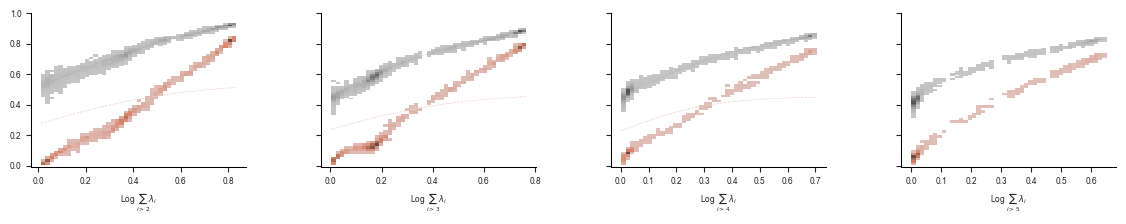

In [9]:
import scipy.optimize as opt
import math
fig = plt.figure(figsize=(14,2))
gs = gridspec.GridSpec(1,4,wspace = .35)
ax0=fig.add_subplot(gs[0,0])
ax1=fig.add_subplot(gs[0,1])
ax2=fig.add_subplot(gs[0,2])
ax3=fig.add_subplot(gs[0,3])
axes = [ax0,ax1,ax2,ax3]

df_list = []
for filename in os.listdir('Experiment_1/Results_1'):
    f = os.path.join('Experiment_1/Results_1', filename)
    if os.path.isfile(f):
        df_list.append(pd.read_pickle(f))
original_df_act = pd.concat(df_list,ignore_index=True) 
original_df_act = original_df_act[original_df_act.mse_z<.035]
#original_df_act = original_df_act[original_df_act.lambda_std==0.1]
##original_df_act = original_df_act[original_df_act.sigma_rec==0]
original_df_act = original_df_act[original_df_act.lr==0.005]
#original_df_act = original_df_act[original_df_act.n==100]
#original_df_act = original_df_act[original_df_act.beta==1.4]
#original_df_act = original_df_act[original_df_act.activity_std<.01]
#original_df_act = original_df_act[original_df_act.beta==5.]


#original_df = original_df[original_df.k>1]
parameters = []
fit_rows = []

for i in range(4):
    ax = axes[i]
    k = i+2
    df = original_df_act.copy()
    df['var'] = df.variance.apply(lambda x: compute_var(x,k))
    df['k_inertia'] = df.inertia.apply(lambda x: x[k])
    #df['var'] = np.log(df['var'])
    #df = df[df.k>=k]
    df = df[df.dim==k]
    print(df.lvar.max())
    #df = df[df['var']<-.35]
    
        # Construct null dataframe
    rows = []
    for index, row in df.iterrows():
        null = row['null_inertia']
        for run in range(null.shape[1]):
            rows.append({'model_id':row['model_id'],
                         'var':row['var'],
                         'sigma_rec': row['sigma_rec'],
                         'lr': row['lr'],
            'run':run,
            'inertia': null[k-1,run]})
    null_df = pd.DataFrame(rows)     
   # null_df = null_df.groupby(['model_id']).mean().reset_index()
    sns.histplot(data=df, x='var',y='k_inertia',ax=ax,legend=False,alpha=1,bins=(45,45),hue = 'lr')
    sns.histplot(data=null_df, x='var',y='inertia',ax=ax,legend=False,alpha=1,bins=(45,45),color='gray')


    def f(x, a,b,c,d):
        #return a + c * np.log(1 + np.exp(b * (x-d))) / b
        #return a + c*np.log(1+np.exp(20 * (x-b)))/20
        return  a + b/(1+np.exp(c*(x-d)))
    # bounds = ([0,0,-np.inf,-np.inf],
    #               [np.inf, np.inf,0,0])
    bounds = ([0,0,-np.inf,-np.inf],
                  [np.inf, np.inf,0,0])
    x_values = np.linspace(df['var'].min(),df['var'].max(),20)
    for lr in [0.001, 0.005]:
        for sample in range(100):   
            #try:
            frac = .1
            sample_df = df[df.lr == lr].sample(frac=frac)
            x = sample_df['var'].values.astype(float)
            y = sample_df.k_inertia.values
    
            sample_null_df = null_df[null_df.lr==lr].sample(frac=frac)
            x_null = sample_null_df['var'].values.astype(float)
            y_null = sample_null_df.inertia.values
    
            try:
                popt, pcov = opt.curve_fit(f, x, y, method="trf",max_nfev=10000,bounds = bounds)
                #popt, pcov = opt.curve_fit(f, x, y, method="trf",max_nfev=10000)
                y_fit = f(x_values, *popt)
    
                for step in range(20):
                    fit_rows.append({'sample':sample,
                                     'step': step,
                                     'k':k,
                                     'lr':lr,
                                 'type': 1,
                                 'x':x_values[step],
                                 'y': y_fit[step],
                                 'a':popt[0]})
            except:
                continue
        

        try:
            popt, pcov = opt.curve_fit(f, x_null, y_null, method="trf",max_nfev=10000,bounds = bounds)
            y_fit = f(x_values, *popt)
            for step in range(20):
                fit_rows.append({'sample':sample,
                                 'step':step,
                                 'k':k,
                                 'lr':lr,
                             'type': 0,
                             'x':x_values[step],
                             'y': y_fit[step],
                             'a':popt[0]})
        except:
           continue
  


fit_df = pd.DataFrame(fit_rows)
for k in range(3):
    ax = axes[k]
    sns.lineplot(data = fit_df[(fit_df.type==1) & (fit_df.k==k+2)], x= 'x', y='y',ax=ax,legend = False,lw=.5,color='tab:blue',alpha = 1,errorbar=None, linestyle='--',hue = 'lr')
    sns.lineplot(data = fit_df[(fit_df.type==0)& (fit_df.k==k+2)], x= 'x', y='y',ax=ax,legend = False,lw=.5,color='gray',linestyle='--',alpha= .25, errorbar = None)

for ax in [ax0,ax1,ax2,ax3]:
#     
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel('', fontsize=8)
    ax.xaxis.set_tick_params(labelsize=6,bottom=True)
    ax.yaxis.set_tick_params(labelsize=6,left=True)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
   # plt.yticks(list(plt.yticks()[0]) + [5.0])
    ax.set_ylim(-.01,1)
    #ax.set_xlim(-10,-2)
ax1.set_yticklabels([])
ax2.set_yticklabels([])
ax3.set_yticklabels([])


ax0.set_xlabel("Log " + r"$\sum_{i>2}\lambda_i$", fontsize=6)
ax1.set_xlabel("Log " +r"$\sum_{i>3}\lambda_i$", fontsize=6)
ax2.set_xlabel("Log " +r"$\sum_{i>4}\lambda_i$", fontsize=6)
ax3.set_xlabel("Log " +r"$\sum_{i>5}\lambda_i$", fontsize=6)
fig.savefig('/Users/cl1704/PycharmProjects/Clustering/Figures/MainFig_1_a.jpg',
    format='jpeg',
    dpi=450,
    bbox_inches='tight'

            )

In [6]:
original_df

NameError: name 'original_df' is not defined

<Axes: xlabel='activity_std', ylabel='Count'>

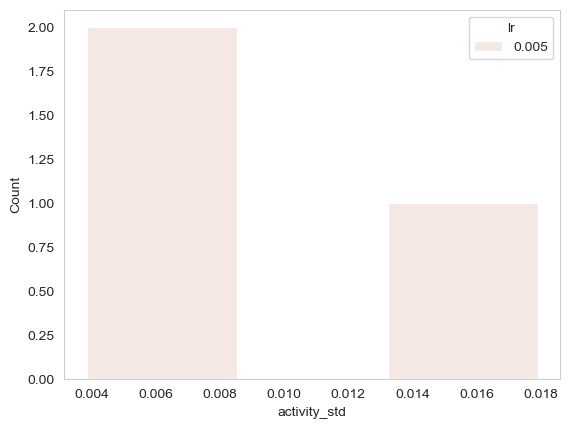

In [6]:
k=2
df = original_df_act.copy()
df['var'] = df.variance.apply(lambda x: compute_var(x,k))
df['k_inertia'] = df.inertia.apply(lambda x: x[k])
df['var'] = np.log(df['var'])
#df = df[df.k>=k]
df = df[df.dim==k]
df = df[df['var']<-4]
df.activity_std = df.activity_std.astype(float)
plt.figure()
sns.histplot(data= df, x = 'activity_std',hue = 'lr')

In [9]:

df_list = []
for filename in os.listdir('Experiment_1/Results_1'):
    f = os.path.join('Experiment_1/Results_1', filename)
    if os.path.isfile(f):
        df_list.append(pd.read_pickle(f))
original_df_act = pd.concat(df_list,ignore_index=True) 
original_df_act = original_df_act[original_df_act.mse_z<.035]
original_df_act = original_df_act[original_df_act.lambda_std==0.4]
original_df_act = original_df_act[original_df_act.sigma_rec==0.]
original_df_act = original_df_act[original_df_act.lr==0.005]
#original_df_act = original_df_act[original_df_act.activity_std<.01]

k = 2
new_df = original_df_act.copy()
new_df['var'] = new_df.variance.apply(lambda x: compute_var(x,k))
new_df['k_inertia'] = new_df.inertia.apply(lambda x: x[k-1])
new_df['var'] = np.log(new_df['var'])
#new_df = new_df[new_df.k>=k]
new_df = new_df[new_df.dim==k]
new_df.sort_values('var',ascending=True)

,model_id,w_rec,w_in,w_out,bias,mse_z,weight_decay,threshold,sigma_rec,lambda_std,...,lvar,dim,k,p_value,inertia,activity_std,null_inertia,variance,var,k_inertia
2994,T1n5smOa,"[[0.0, 0.001234026, -0.052101653, -0.003586580...","[[-0.034337297, -0.0007821807], [0.13146386, -...","[[0.25213653, 0.00953815, 0.1282984, 0.0135795...","[0.07767935, 0.0018679115, 0.1391639, 0.007772...",0.028899,0.001,0.025,0.0,0.4,...,0.177828,2,3,0.0,"[0.49780177486097416, 0.25072837571540313, 0.0...",0.00712535,"[[0.9964515211578868, 0.9976211288966678, 0.99...","[0.7276882, 0.24980804, 0.019724878, 0.0016501...",-3.794071,0.250728
2848,Tuy6rZYh,"[[0.0, -0.032331243, -0.017521225, 0.008727062...","[[-0.09562893, -0.016768523], [-0.04756456, 0....","[[0.04231965, 0.13507468, 0.013384173, 0.38216...","[0.028736362, 0.049567465, 0.0481075, 0.090373...",0.029747,0.001,0.025,0.0,0.4,...,0.056234,2,3,0.0,"[0.8705346657633243, 0.04709559550022584, 0.02...",0.015508405,"[[0.997828772650679, 0.9945356991383196, 0.993...","[0.84929883, 0.12014451, 0.024552297, 0.002724...",-3.488170,0.047096
2920,C4mbpDT8,"[[0.0, -0.00040833585, 0.004261597, 0.00791602...","[[-0.058637626, 0.13905656], [-0.0022663926, -...","[[0.0804867, 0.36675337, 0.064158, 0.08297191,...","[0.01053837, 0.10826324, 0.0103564495, 0.01210...",0.034501,0.001,0.025,0.0,0.4,...,0.133352,2,4,0.0,"[0.6809310431380368, 0.3416291788866374, 0.026...",0.004513012,"[[0.9960693838554028, 0.9845453618951171, 0.99...","[0.6524794, 0.3049275, 0.028734284, 0.01179000...",-3.156060,0.341629
3076,KZ9pnU7s,"[[0.0, -0.05028169, 0.009165385, -0.024140593,...","[[-0.080596596, 0.14070301], [-0.0142329745, -...","[[-0.01842947, 0.1043555, 0.018674418, 0.41642...","[0.053726416, 0.119029045, -0.001912556, 0.129...",0.029698,0.001,0.025,0.0,0.4,...,0.237137,2,3,0.0,"[0.9105187074829932, 0.3456346450617284, 0.007...",0.012251571,"[[0.9971984856251227, 0.9988233871296893, 0.99...","[0.5657888, 0.39134178, 0.036535323, 0.0041310...",-3.149596,0.345635
2692,hzwR9KdS,"[[0.0, 0.00995647, -0.0032365462, 0.00432121, ...","[[-0.074854024, 0.1347311], [-0.073266156, 0.1...","[[0.10229318, 0.118357256, 0.0022106222, 0.091...","[0.029307462, 0.034801275, 0.05856074, 0.02479...",0.031465,0.001,0.025,0.0,0.4,...,0.100000,2,4,0.0,"[0.7493669174871206, 0.28154777920156027, 0.03...",0.0053239833,"[[0.9938427046233322, 0.9992969513446616, 0.99...","[0.49559522, 0.45901406, 0.030336363, 0.012203...",-3.092447,0.281548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1207,tItBQK9S,"[[0.0, 0.026515983, 0.023802496, 0.023240117, ...","[[0.19016376, -0.1798076], [-0.13050973, -0.07...","[[0.03882334, 0.16731323, 0.18188961, 0.007890...","[-0.018064337, 0.07217583, 0.032588407, -0.098...",0.025155,0.001,0.025,0.0,0.4,...,-0.316228,2,5,0.0,"[0.9547265928515929, 0.8838545713545714, 0.823...",0.004419782,"[[0.9898209530474934, 0.9917151080444496, 0.99...","[0.10127259, 0.091502905, 0.08457155, 0.079715...",-0.214154,0.883855
1217,PfxHZ3b8,"[[0.0, -0.026715633, -0.064394005, -0.05155197...","[[-0.0021947967, 0.07838191], [0.2307304, -0.1...","[[0.109013245, 0.007822613, 0.036684904, 0.159...","[0.02559871, -0.10528411, -0.017910428, -0.009...",0.027221,0.001,0.025,0.0,0.4,...,-0.316228,2,5,0.0,"[0.9530683609141056, 0.8772226326503809, 0.816...",0.0049062637,"[[0.9936518067051779, 0.9832037988128202, 0.99...","[0.10000063, 0.09271162, 0.0905606, 0.08522631...",-0.214075,0.877223
969,tgarhcqH,"[[0.0, -0.073897615, -0.02196925, -0.019803721...","[[-0.06737507, 0.037100885], [-0.014068496, -0...","[[-0.043951936, 0.4315435, 0.009624542, 0.0160...","[0.11029392, 0.081862554, -0.104151234, -0.088...",0.031459,0.001,0.025,0.0,0.4,...,-0.421697,2,5,0.0,"[0.9571930818229577, 0.8904600078802206, 0.829...",0.006129445,"[[0.9939626590312202, 0.9899057416697103, 0.98...","[0.10430225, 0.08785335, 0.08599953, 0.0806907...",-0.213386,0.890460
739,q7L0XnXh,"[[0.0, -0.08240289, 0.06682777, -0.041067682, ...","[[-0.0275

In [11]:
from Experiment_1.net import *
model_data = new_df[new_df.model_id=='T1n5smOa']
net = Net(n=150,input_size = 2,dale=False)
net.recurrent_layer.weight.data = torch.tensor(model_data['w_rec'].item())
net.recurrent_layer.bias.data = torch.tensor(model_data['bias'].item())
net.input_layer.weight.data = torch.tensor(model_data['w_in'].item())
net.output_layer.weight.data = torch.tensor(model_data['w_out'].item())
variance = model_data['var'].item()
u, z, mask, conditions  = generate_trials(
                            n_trials=25)
x = net(u).detach().cpu().numpy()

rows = []
for k in range(u.shape[0]):
    rows.append({'trial': k,
                 'motion': conditions[k]['motion_coh'],
                 'response': x[k, :, :]})
df = pd.DataFrame(rows)
df = df.groupby(['motion']).response.apply(lambda r: np.mean(np.stack(r), axis=0)).reset_index()

#df = df.groupby('motion').response.apply(lambda r: np.mean(np.stack(r), axis=0)).reset_index()
responses = np.stack(df.response.values)
responses = responses.reshape(-1, responses.shape[2]).T

#responses = responses[np.mean(responses, axis=1) >.15, :]

# z_score
responses = (responses - np.mean(responses, axis=1, keepdims=True)) / np.std(responses, axis=1, keepdims=True)
responses = responses[~np.isnan(responses).any(axis=1)]



In [53]:
np.sum(np.array(null)<inertia)/250

0.084